<a href="https://colab.research.google.com/github/martijnhabers/GPT-DT/blob/depth_estimation/ZOEdepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.4 MB/s eta 0:00:00


Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


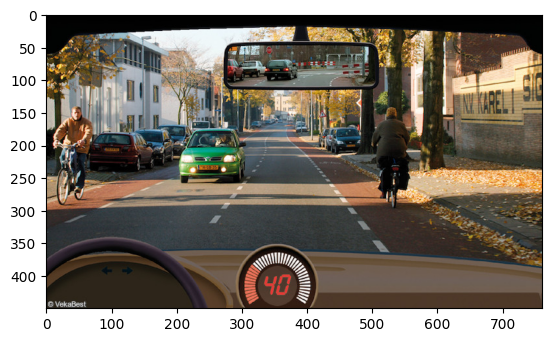

Saved raw depth to /content/drive/MyDrive/ZOE probeersels/Test.png


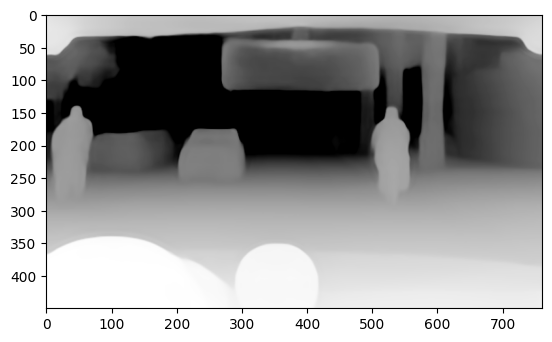

   class_naam        Dist    RGB
0         car         far   75.0
1         car         far   71.0
2         car     too far    0.0
3      person       close  154.0
4         car         far   63.0
5         car     too far    0.0
6         car  medium far  110.0
7         car     too far    0.0
8         car     too far    1.0
9      person       close  163.0
10    bicycle       close  156.0
11        car         far   94.0
12        car  medium far  127.0
13    bicycle       close  167.0


In [42]:

import torch
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import math

repo = "isl-org/ZoeDepth"
#torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)

# Zoe_K
#model_zoe_k = torch.hub.load(repo, "ZoeD_K", pretrained=True)

# Zoe_NK
model_zoe_nk = torch.hub.load(repo, "ZoeD_NK", pretrained=True)

##### sample prediction
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe = model_zoe_nk.to(DEVICE)

# Local file
image = Image.open("/content/drive/MyDrive/ZOE probeersels/Images/vraag 1.jpg").convert("RGB")  # load
depth_numpy = zoe.infer_pil(image)  # as numpy
plt.imshow(image)
plt.show()

depth_pil = zoe.infer_pil(image, output_type="pil")  # as 16-bit PIL Image

depth_tensor = zoe.infer_pil(image, output_type="tensor")  # as torch tensor

# Tensor 
from zoedepth.utils.misc import pil_to_batched_tensor
X = pil_to_batched_tensor(image).to(DEVICE)
depth_tensor = zoe.infer(X)

#image = get_image_from_url(URL)  # fetch
depth = zoe.infer_pil(image)

# Save raw
from zoedepth.utils.misc import save_raw_16bit
fpath = "/content/drive/MyDrive/ZOE probeersels/Test.png"
save_raw_16bit(depth, fpath)

# Colorize output
from zoedepth.utils.misc import colorize

colored = colorize(depth)

# save colored output
Image.fromarray(colored).save("/content/drive/MyDrive/ZOE probeersels/Test_colored.png")

# display image
image = Image.open("/content/drive/MyDrive/ZOE probeersels/Test_colored.png")
plt.imshow(image)
plt.show()

from PIL import Image
import csv

# Load image
img = Image.open("/content/drive/MyDrive/ZOE probeersels/Test_colored.png")
width, height = img.size

# Open CSV file
loc_sheet = "/content/drive/MyDrive/ZOE probeersels/CSV/dataframe_voor_depth_1.csv"
df = pd.read_csv(r'%s' %(loc_sheet), index_col = 0) #df = pd.read_excel(r'...')

#TABLE
classnum_name = 'class'
xmid_name = 'x_midden'
ymid_name = 'y_midden'
b_name = 'breedte'
h_name = 'hoogte'
pred_name = 'predictions'
class_name = 'class_naam'
state_name = 'state'
foto_name = 'foto_naam'
hp_name = 'height_position'
wp_name = 'width_position'
pos_name = 'position'

        #Define distances
     #   closeness = pixel_color[0]
      #  if 151 > closeness > 100: 
    #      distance = "medium far"
    #    elif 51 < closeness < 150:
   #       distance = "far"
       # elif closeness < 50:
      #    continue
     #  else: 
     #     distance = "close"

Dist = pd.DataFrame(df.loc[:,'%s'%(class_name)])
Dist['Dist'] = np.zeros(len(Dist.index))
for r in range(0,len(df.index)):
      x = df.loc[r,'%s'%xmid_name]
      y = df.loc[r,'%s'%ymid_name]
      R,G,B,O = img.getpixel((x, y))
      Dist.loc[r,'RGB'] = R
      if R <= 50:
        Dist.loc[r,'Dist'] = 'too far'
      elif 50 < R <= 100:
        Dist.loc[r,'Dist'] = 'far'
      elif 100 < R <= 150:
        Dist.loc[r,'Dist'] = 'medium far'
      else:
        Dist.loc[r,'Dist'] = 'close'
      
print(Dist)

      